Getting projections



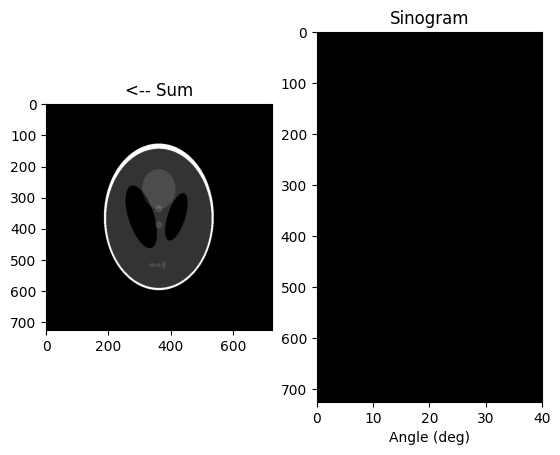

Filtering

Performing backprojection


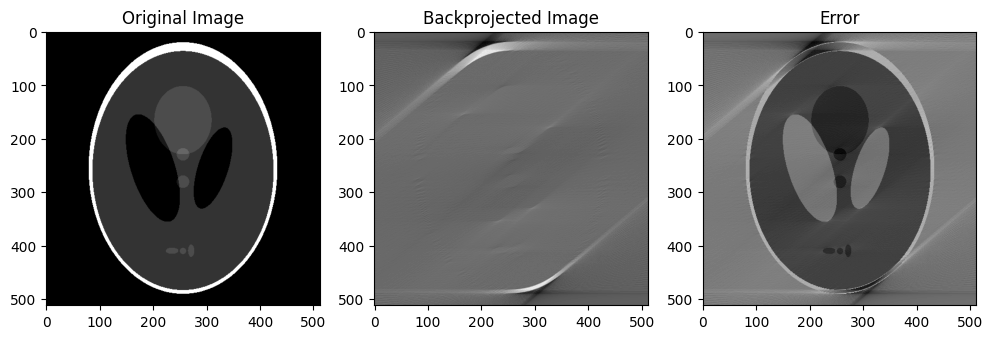

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
from scipy.fftpack import fft, fftshift, ifft

def dummyImg(size0, size1):
    """this just creates a silly 8-bit image consisting of a solid rectangle
    inputs: size0, size1 - dimensions of image in pixels
    output: dumImg - PIL image object"""
    M = np.zeros((size0, size1))
    a = round(size0/4)
    b = round(size1/4)
    M[a:size0-a,b:size1-b] = 255 #insert centered rectangle with dimensions 1/2 the size of the image
    dumImg = Image.fromarray(M.astype('uint8'))  #create image object
    return dumImg

def padImage(img):
    """pad images with zeros such that new image is a square with sides equal to
    the diagonal of the original in size. Return padded image as well as coordinates
    of upper-left coordinates where original image is implanted"""
    N0, N1 = img.size
    lenDiag = int(np.ceil(np.sqrt(N0**2+N1**2)))
    imgPad = Image.new('L',(lenDiag, lenDiag))
    c0, c1 = int(round((lenDiag-N0)/2)), int(round((lenDiag-N1)/2)) #coordinates of top-left corner in which to paste image
    imgPad.paste(img, (c0,c1))
    return imgPad, c0, c1

def getProj(img, theta):
    """this rotates an image by an array of angles and takes projections.
    Note that we pad the image beforehand rather than allow the rotate method
    to expand the image because the image expands to different sizes depending
    on the angle of rotation. We need to expand every rotated image to the
    same size so that we can collect the contributions into the same vector.
    inputs:  img - PIL image object
             theta - 1D numpy array of angles over which to compute projections
    output: sinogram - projections of img over theta (effectively the radon transform)"""

    numAngles = len(theta)
    sinogram = np.zeros((img.size[0],numAngles))

    #set up plotting
    plt.ion()
    fig1, (ax1, ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(img, cmap='gray')
    ax1.set_title('<-- Sum')
    im2 = ax2.imshow(sinogram, extent=[theta[0],theta[-1], img.size[0]-1, 0],
                     cmap='gray', aspect='auto')
    ax2.set_xlabel('Angle (deg)')
    ax2.set_title('Sinogram')
    plt.show()

    #get projections an dplot
    for n in range(numAngles):
        rotImgObj = img.rotate(90-theta[n], resample=Image.BICUBIC)
        im1.set_data(rotImgObj)
        sinogram[:,n] = np.sum(rotImgObj, axis=0)
        im2.set_data(Image.fromarray((sinogram-np.min(sinogram))/np.ptp(sinogram)*255))
        fig1.canvas.draw()
        fig1.canvas.flush_events()

    plt.ioff()
    return sinogram

def arange2(start, stop=None, step=1):
    """#Modified version of numpy.arange which corrects error associated with non-integer step size"""
    if stop == None:
        a = np.arange(start)
    else:
        a = np.arange(start, stop, step)
        if a[-1] > stop-step:
            a = np.delete(a, -1)
    return a

def projFilter(sino):
    """filter projections. Normally a ramp filter multiplied by a window function is used in filtered
    backprojection. The filter function here can be adjusted by a single parameter 'a' to either approximate
    a pure ramp filter (a ~ 0)  or one that is multiplied by a sinc window with increasing cutoff frequency (a ~ 1).
    Credit goes to Wakas Aqram.
    inputs: sino - [n x m] numpy array where n is the number of projections and m is the number of angles used.
    outputs: filtSino - [n x m] filtered sinogram array"""

    a = 0.1;
    projLen, numAngles = sino.shape
    step = 2*np.pi/projLen
    w = arange2(-np.pi, np.pi, step)
    if len(w) < projLen:
        w = np.concatenate([w, [w[-1]+step]]) #depending on image size, it might be that len(w) =
                                              #projLen - 1. Another element is added to w in this case
    rn1 = abs(2/a*np.sin(a*w/2));  #approximation of ramp filter abs(w) with a funciton abs(sin(w))
    rn2 = np.sin(a*w/2)/(a*w/2);   #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2;              #modulation of ramp filter with sinc window

    filt = fftshift(r)
    filtSino = np.zeros((projLen, numAngles))
    for i in range(numAngles):
        projfft = fft(sino[:,i])
        filtProj = projfft*filt
        filtSino[:,i] = np.real(ifft(filtProj))

    return filtSino

def backproject(sinogram, theta):
    """Backprojection function.
    inputs:  sinogram - [n x m] numpy array where n is the number of projections and m the number of angles
             theta - vector of length m denoting the angles represented in the sinogram
    output: backprojArray - [n x n] backprojected 2-D numpy array"""
    imageLen = sinogram.shape[0]
    reconMatrix = np.zeros((imageLen, imageLen))

    x = np.arange(imageLen)-imageLen/2 #create coordinate system centered at (x,y = 0,0)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    plt.ion()
    fig2, ax = plt.subplots()
    im = plt.imshow(reconMatrix, cmap='gray')

    theta = theta*np.pi/180
    numAngles = len(theta)

    for n in range(numAngles):
        Xrot = X*np.sin(theta[n])-Y*np.cos(theta[n]) #determine rotated x-coordinate about origin in mesh grid form
        XrotCor = np.round(Xrot+imageLen/2) #shift back to original image coordinates, round values to make indices
        XrotCor = XrotCor.astype('int')
        projMatrix = np.zeros((imageLen, imageLen))
        m0, m1 = np.where((XrotCor >= 0) & (XrotCor <= (imageLen-1))) #after rotating, you'll inevitably have new coordinates that exceed the size of the original
        s = sinogram[:,n] #get projection
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]  #backproject in-bounds data
        reconMatrix += projMatrix
        im.set_data(Image.fromarray((reconMatrix-np.min(reconMatrix))/np.ptp(reconMatrix)*255))
        ax.set_title('Theta = %.2f degrees' % (theta[n]*180/np.pi))
        fig2.canvas.draw()
        fig2.canvas.flush_events()

    plt.close()
    plt.ioff()
    backprojArray = np.flipud(reconMatrix)
    return backprojArray

#def main():
if __name__ == '__main__':

    #myImg = dummyImg(500,700)
    myImg = Image.open('SheppLogan.png').convert('L')

    myImgPad, c0, c1 = padImage(myImg)  #PIL image object
    dTheta = 1
    theta = np.arange(0,41,dTheta)
    print('Getting projections\n')
    mySino = getProj(myImgPad, theta)  #numpy array
    print('Filtering\n')
    filtSino = projFilter(mySino)  #numpy array
    print('Performing backprojection')

    recon = backproject(filtSino, theta)
    recon2 = np.round((recon-np.min(recon))/np.ptp(recon)*255) #convert values to integers 0-255
    reconImg = Image.fromarray(recon2.astype('uint8'))
    n0, n1 = myImg.size
    reconImg = reconImg.crop((c0, c1, c0+n0, c1+n1))

    fig3, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    ax1.imshow(myImg, cmap='gray')
    ax1.set_title('Original Image')
    ax2.imshow(reconImg, cmap='gray')
    ax2.set_title('Backprojected Image')
    ax3.imshow(ImageChops.difference(myImg, reconImg), cmap='gray') #note this currently doesn't work for imported images
    ax3.set_title('Error')
    plt.show()

In [6]:
mySino.shape

(725, 181)

In [9]:
myImg.reshape(400,400)

AttributeError: reshape

In [16]:
import skimage
gt_img = skimage.data.shepp_logan_phantom()
np.save("shepp.npy", gt_img)

In [32]:
img1 = np.load("FBP-REC_40 Angles.npy")

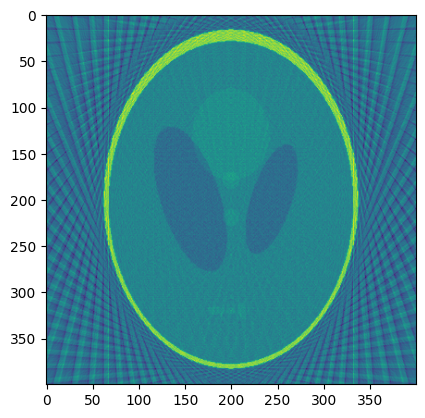

In [33]:
plt.imshow(img1)
plt.show()

In [43]:
def normalize(data):
    max = data.max()
    min = data.min()
    return (data-min)/(max-min)

In [37]:
img2 = np.load("FBP-REC_40 Angles_Noisy2.npy")

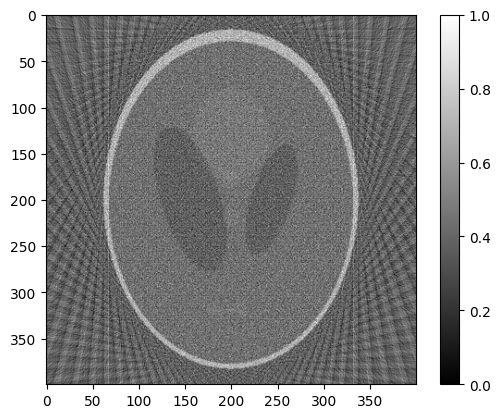

In [44]:
plt.imshow(normalize(img2), cmap="gray")
plt.colorbar()
plt.show()

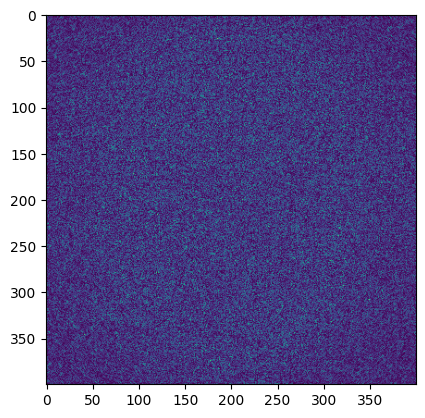

In [39]:
plt.imshow(abs(img1-img2))
plt.show()

In [49]:
from skimage.metrics import peak_signal_noise_ratio

peak_signal_noise_ratio(normalize(gt_img), normalize(img2).astype("float64"))

9.35090754432689

In [48]:
gt_img.dtype

dtype('float64')